# KUKA - Document Rectification
Perspective rectification and background croping

### Reference
https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [1]:
import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

# from importlib import reload,import_module
# m = import_module("kukalib.cardcrop")
# reload(m)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.2.4', 'date': datetime.date(2023, 5, 24)}


## Load image

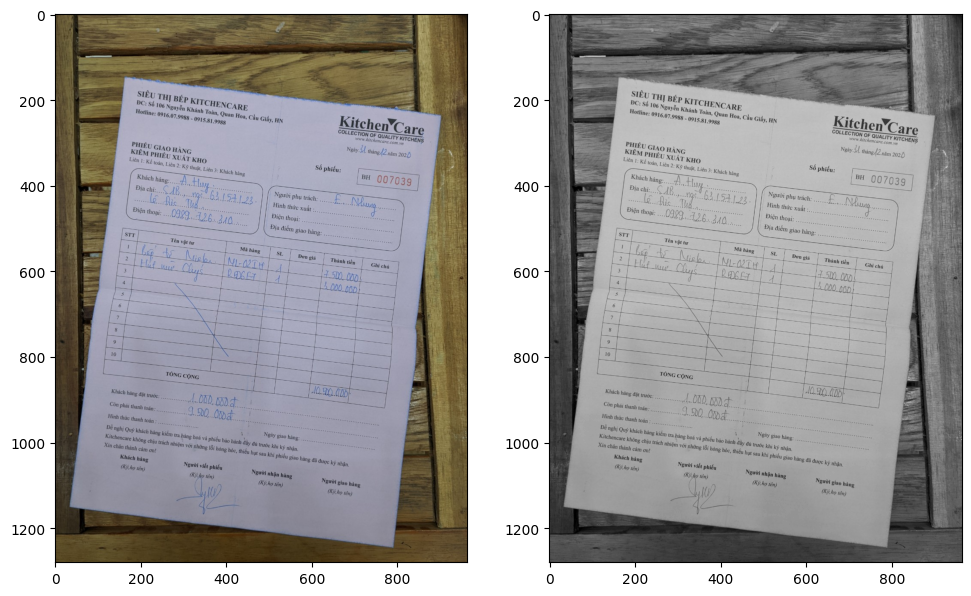

In [25]:
filename=r"D:\Google-drive-huy-work\imagedata\xemay\img35.jpg" #not ok
filename=r"D:\Google-drive-huy-work\imagedata\skew\train\images\img_5.jpg"

src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

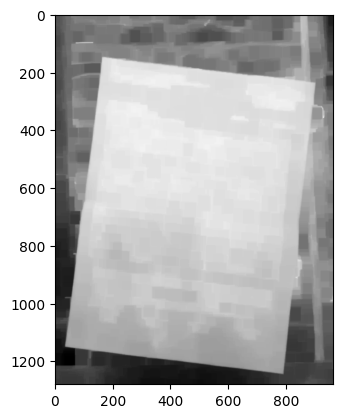

In [26]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [27]:
sobelImg=sobel(blurImg)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

lines = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line: 120


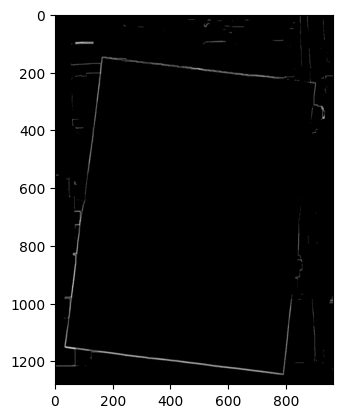

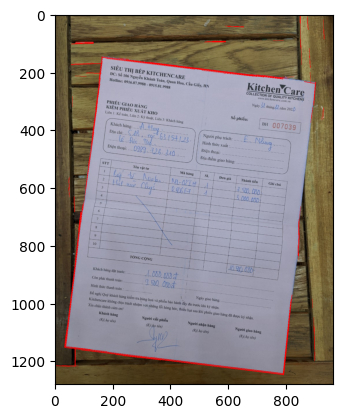

In [28]:
# print debug line
lineImg=src.copy()
print('Num of line:', len(lines))
for line in lines:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(0,0,255),1)

plt.imshow(edgeImg,cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

### version 1: select quadrangle based on the length of line

In [29]:
x=0
y=0
w=src.shape[1]
h=src.shape[0]

#assumpt: card is center of image and the skew angle is less than 45 degree
xcenter=w/2
ycenter=h/2

hLine=(x,y+h/2,x+w,y+h/2)
vLine=(x+w/2,y, x+w/2,y+h)

hLine=np.array(hLine).astype(np.int32)
vLine=np.array(vLine).astype(np.int32)

maxTLineLen=0
maxBLineLen=0
maxLLineLen=0
maxRLineLen=0
topline=[]
bottomline=[]
leftline=[]
rightline=[]
topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]


for line in lines:
    p1=line[0][0:2]
    p2=line[0][2:4]
    angle= getLineAngle(p1,p2)
    angle=abs(angle)

    length=getLineLength(p1,p2)
    if(angle<45): # top/bottom line
        if(p1[1]+p2[1])/2 < ycenter:
            if maxTLineLen<length:
                maxTLineLen=length
                topline=line[0]
        elif (p1[1]+p2[1])/2 > ycenter:
            if maxBLineLen<length:
                maxBLineLen=length
                bottomline=line[0]
    else:
        if (p1[0]+p2[0])/2 < xcenter:
            if maxLLineLen<length:
                maxLLineLen=length
                leftline=line[0]
        elif (p1[0]+p2[0])/2 > xcenter:
            if maxRLineLen<length:
                maxRLineLen=length
                rightline=line[0]

'draw line to debug image'
if len(topline)>0:
    cv2.line(lineImg,topline[0:2],topline[2:4],255,1)
if len(bottomline)>0:
    cv2.line(lineImg,bottomline[0:2],bottomline[2:4],255,1)
if len(leftline)>0:
    cv2.line(lineImg,leftline[0:2],leftline[2:4],255,1)
if len(rightline)>0:
    cv2.line(lineImg,rightline[0:2],rightline[2:4],255,1)

if(len(topline)>0 and len(bottomline)>0 and len(leftline)>0 and len(rightline)>0):
    # tính hệ số (a,b,c) của các đường thẳng
    aL,bL,cL=calcParams(leftline[0:2],leftline[2:4])
    aT,bT,cT=calcParams(topline[0:2],topline[2:4])

    aR,bR,cR=calcParams(rightline[0:2],rightline[2:4])
    aB,bB,cB=calcParams(bottomline[0:2],bottomline[2:4])

    # tìm các giao điểm tl,tr,bl,br
    topleftPoint=findIntersection((aL,bL,cL),(aT,bT,cT))
    toprightPoint=findIntersection((aR,bR,cR),(aT,bT,cT))
    bottomleftPoint=findIntersection((aL,bL,cL),(aB,bB,cB))
    bottomrightPoint=findIntersection((aR,bR,cR),(aB,bB,cB))

    # check if the polygon has four point
    corners=np.array([topleftPoint,toprightPoint,bottomleftPoint,bottomrightPoint])

    corners = order_points(corners)
    
    destination_corners = find_dest(corners)
    
    h, w = src.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    cropedImg = cv2.warpPerspective(src, M, (destination_corners[2][0], destination_corners[2][1]),
                                    flags=cv2.INTER_LINEAR)

    
    #show debug: middle vertical,hozirontal line of boundingbox
    x,y,w,h=cv2.boundingRect(np.float32(corners))
    w2=int(w/2)
    h2=int(h/2)
    
    cv2.line(lineImg,(x,y+h2),(x+w,y+h2),(0,0,255),5) #horizontal
    cv2.line(lineImg,(x+w2,y),(x+w2,y+h),(0,0,255),5) # vertical

    cv2.circle(lineImg,topleftPoint,3,(0,0,255),3)
    cv2.circle(lineImg,toprightPoint,3,(0,0,255),3)
    cv2.circle(lineImg,bottomleftPoint,3,(0,0,255),3)
    cv2.circle(lineImg,bottomrightPoint,3,(0,0,255),3)
    
    cv2.line(lineImg,topleftPoint,toprightPoint,(0,0,255),3)
    cv2.line(lineImg,toprightPoint,bottomrightPoint,(0,0,255),3)
    cv2.line(lineImg,bottomrightPoint,bottomleftPoint,(0,0,255),3)
    cv2.line(lineImg,bottomleftPoint,topleftPoint,(0,0,255),3)

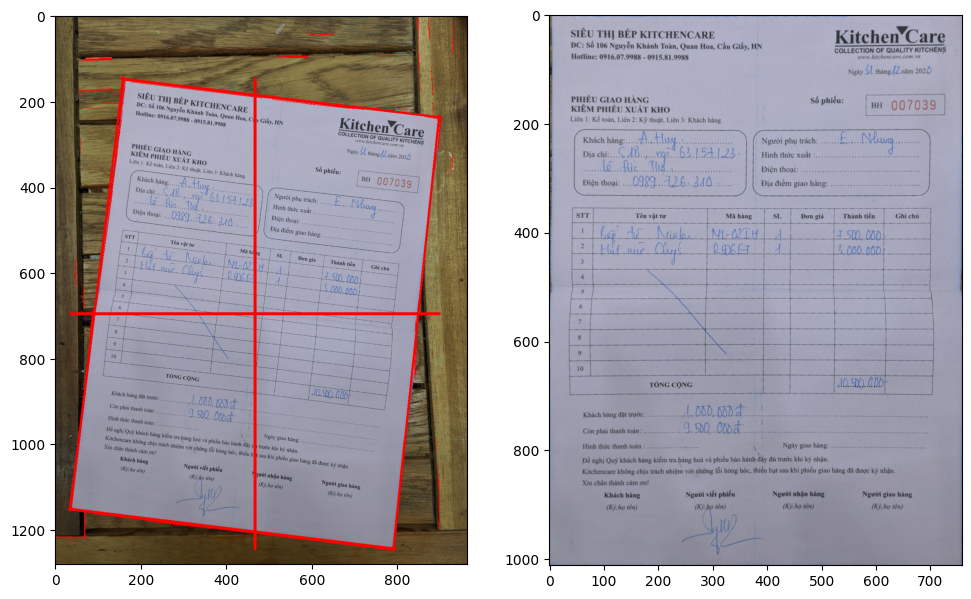

In [30]:
#show debug: middle vertical,hozirontal line of boundingbox
x,y,w,h=cv2.boundingRect(np.float32(corners))
w2=int(w/2)
h2=int(h/2)

cv2.line(lineImg,(x,y+h2),(x+w,y+h2),(0,0,255),5) #horizontal
cv2.line(lineImg,(x+w2,y),(x+w2,y+h),(0,0,255),5) # vertical

cv2.circle(lineImg,topleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,toprightPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomrightPoint,3,(0,0,255),3)

cv2.line(lineImg,topleftPoint,toprightPoint,(0,0,255),3)
cv2.line(lineImg,toprightPoint,bottomrightPoint,(0,0,255),3)
cv2.line(lineImg,bottomrightPoint,bottomleftPoint,(0,0,255),3)
cv2.line(lineImg,bottomleftPoint,topleftPoint,(0,0,255),3)


figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
plt.show()



### version 2: select quadrangle based on criterion of angles of line

Total line: 120
Topline: 38 - Bottomline:13 - Leftline:32 - RightLine:37
Lines top: [161 147 787 223 631   7] bottom: [  32 1151  790 1244  764    7] left: [  36 1154   96  660  498   83] right[ 789 1245  818  971  276   84]
Angle A:90.00	B:90.88	C:90.95	D:90.07
Meet criterion 1: True
	Line angle of Top 7.00 - bottom 7.00  - left: 83.00 - right: 84.00 
Meet criterion 2: True
Meet criterion 3: True
num of selected quadrangle: 1


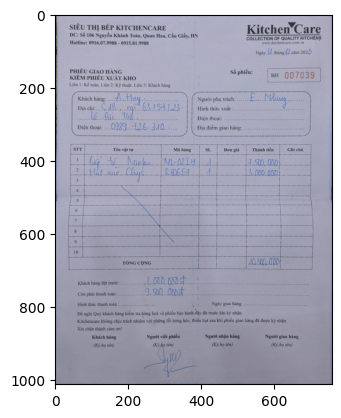

Lines top: [161 147 787 223 631   7] bottom: [  32 1151  790 1244  764    7] left: [  36 1154   96  660  498   83] right[ 789 1245  818  971  276   84]
Angle A:90.00	B:90.88	C:90.95	D:90.07
Meet criterion 1: True
	Line angle of Top 7.00 - bottom 7.00  - left: 83.00 - right: 84.00 
Meet criterion 2: True
Meet criterion 3: True


In [31]:
x=0
y=0
w=src.shape[1]
h=src.shape[0]

#assumpt: card is center of image and the skew angle is less than 45 degree
xcenter=w/2
ycenter=h/2

hLine=(x,y+h/2,x+w,y+h/2)
vLine=(x+w/2,y, x+w/2,y+h)

hLine=np.array(hLine).astype(np.int32)
vLine=np.array(vLine).astype(np.int32)

maxTLineLen=0
maxBLineLen=0
maxLLineLen=0
maxRLineLen=0
topline=[]
bottomline=[]
leftline=[]
rightline=[]
topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]

toplineList=[]
bottomlineList=[]
leftlineList=[]
rightlineList=[]
selectedQuadrangleList=[]

# grouping lines in top,bottom,left,right

for line in lines:
    p1=line[0][0:2]
    p2=line[0][2:4]
    angle= getLineAngle(p1,p2)
    linelength=getLineLength(p1,p2)
    angle=abs(angle)
    lineExtend=np.append(line[0],[round(linelength),round(angle)])
    if(angle<=45): # top/bottom line
        if(p1[1]+p2[1])/2 < ycenter:
            toplineList.append(lineExtend)
        elif (p1[1]+p2[1])/2 > ycenter:
            bottomlineList.append(lineExtend)
    else:
        if (p1[0]+p2[0])/2 < xcenter:
            leftlineList.append(lineExtend)
        elif (p1[0]+p2[0])/2 > xcenter:
            rightlineList.append(lineExtend)

print("Topline: {} - Bottomline:{} - Leftline:{} - RightLine:{}".format(len(toplineList),len(bottomlineList),len(leftlineList),len(rightlineList)))

# converting list(object) to ndarray then sorting length by descending
toplineList = np.vstack(toplineList)
bottomlineList = np.vstack(bottomlineList)
leftlineList= np.vstack(leftlineList)
rightlineList = np.vstack(rightlineList)

toplineList = toplineList[toplineList[:,4].argsort()[::-1]]
bottomlineList = bottomlineList[bottomlineList[:,4].argsort()[::-1]]
leftlineList = leftlineList[leftlineList[:,4].argsort()[::-1]]
rightlineList = rightlineList[rightlineList[:,4].argsort()[::-1]]

stopSearching = False
for topline in toplineList:
    if stopSearching: 
        break
    for bottomline in bottomlineList:
        if stopSearching:
            break
        for leftline in leftlineList:
            if stopSearching:
                break
            for rightline in rightlineList:
                criterionResult,checkResult = verifyQuadrilateral(topline,bottomline,leftline,rightline,True)
                if(checkResult):
                    selectedQuadrangleList.append([topline,bottomline,leftline,rightline])
                    stopSearching=checkResult
                if stopSearching:
                    break

for q in selectedQuadrangleList:
    topline=q[0]
    bottomline=q[1]
    leftline=q[2]
    rightline=q[3]
    cropedImg,lineImg,_ = cropImage(src,topline[0:4],bottomline[0:4],leftline[0:4],rightline[0:4])
    plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
    plt.show()
    verifyQuadrilateral(topline,bottomline,leftline,rightline,True)


In [32]:
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
print (X.shape)

(2, 3)
